# Tuning of Baseline models

In [ ]:
import numpy as np
import pandas as pd
from prep import TimeWindowTransformer, LabelWindowExtractor

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# adjust import if needed

## Baseline models - guided

In [ ]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'guided' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_windows = tw_transformer.transform(X)     # shape: (5, n_windows, 8, 500)
Y_labels = label_extractor.transform(Y)     # shape: (5, n_windows, 51)

# Inspect shapes
print("X_windows shape:", X_windows.shape)
print("Y_labels shape:", Y_labels.shape)

X_windows shape: (5, 919, 8, 500)
Y_labels shape: (5, 919, 51)


In [5]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

### Time features pipelines

In [6]:
from prep import TimeDomainTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from validation import RMSE, NMSE, cross_validate_pipeline

In [7]:
baseline1 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.001,
            kernel='laplacian'))
    ]
)

baseline2 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ]
)

baseline3 = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer()),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ]
)

In [9]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline1,
    'Time domain features + KNN': baseline2,
    'Time domain features + Random Forests': baseline3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)



Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.0181, val=5.1703
NMSE: train=0.0000, val=0.1351

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=2.0971, val=4.7569
NMSE: train=0.0219, val=0.1144

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=1.1835, val=5.1831
NMSE: train=0.0070, val=0.1388


#### Hyperparameter tuning

In [14]:
from sklearn.model_selection import ParameterGrid

param_grids = {
    'Time domain features + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'regressor__gamma': [0.001, 0.01, 0.1],
        'regressor__kernel': ['rbf', 'laplacian', 'poly']
    },
    'Time domain features + KNN': {
        'regressor__n_neighbors': [3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50]
    },
    'Time domain features + Random Forests': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}")
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Tuning Model: Time domain features + Kernel Ridge

Tuning Model: Time domain features + KNN

Tuning Model: Time domain features + Random Forests


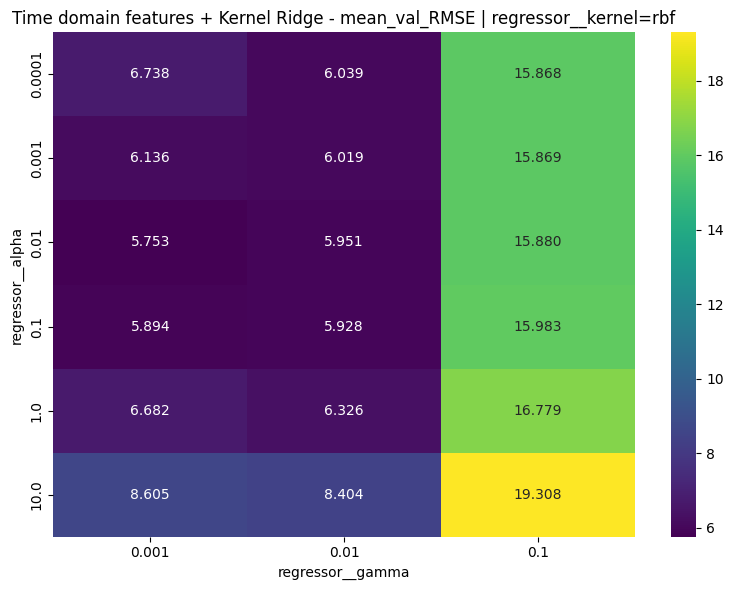

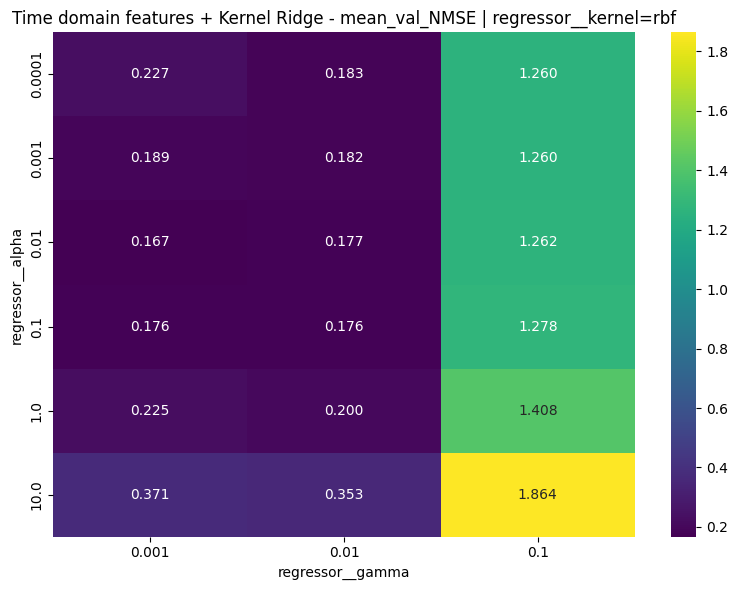

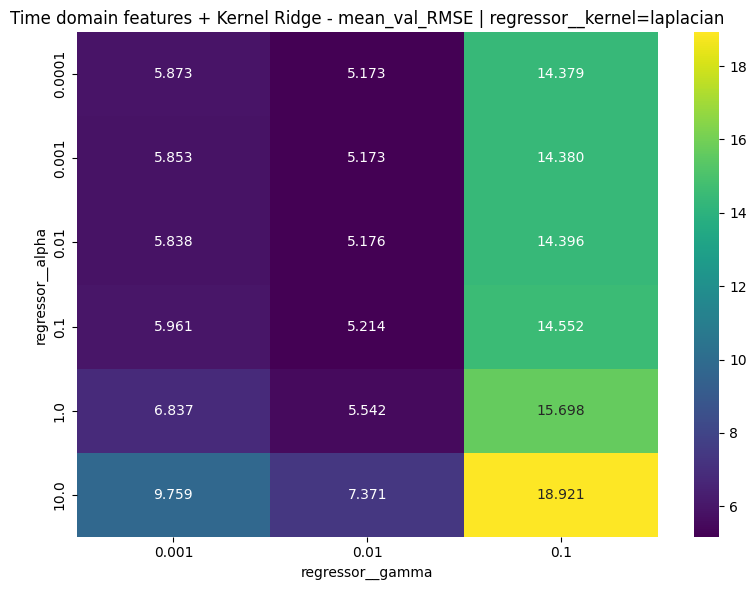

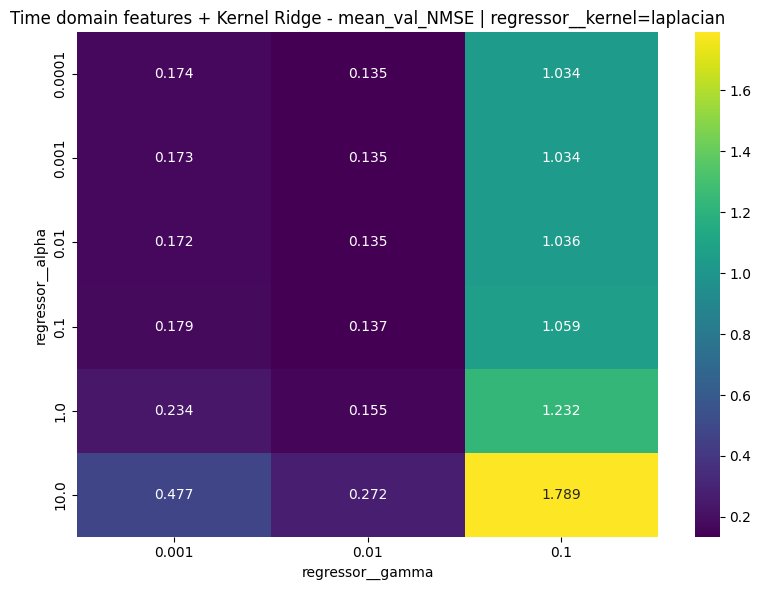

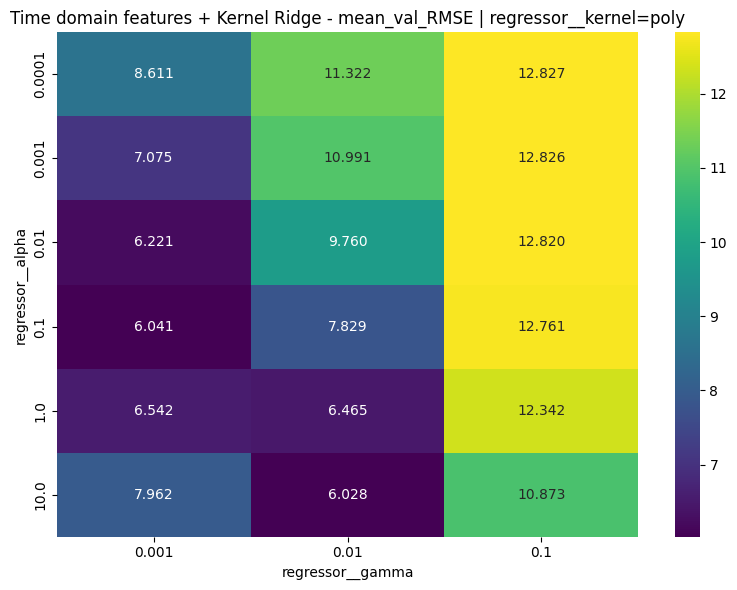

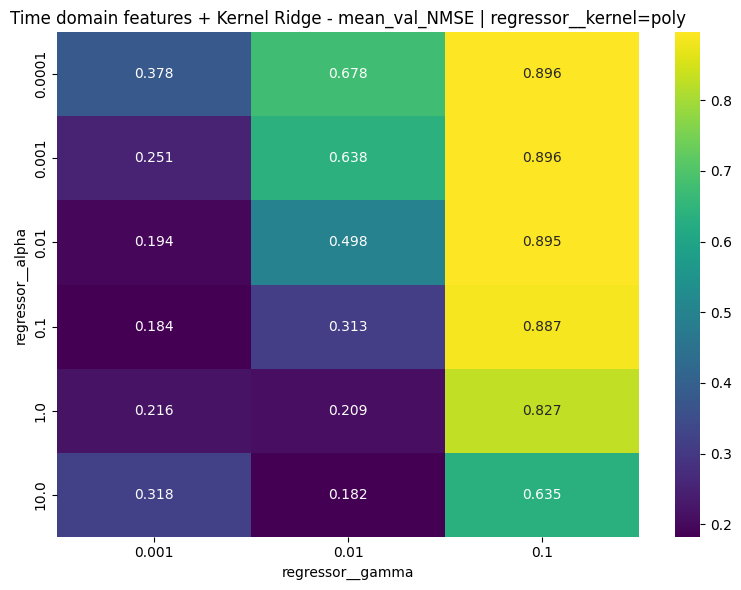

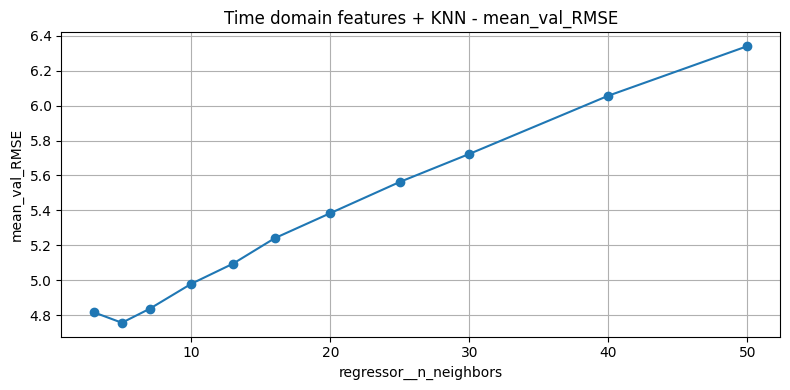

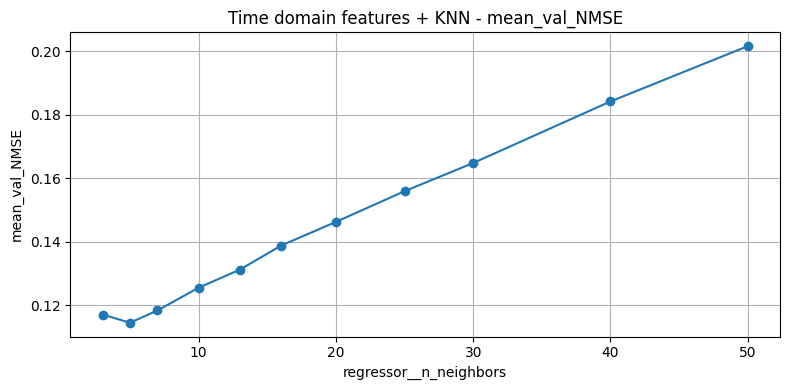

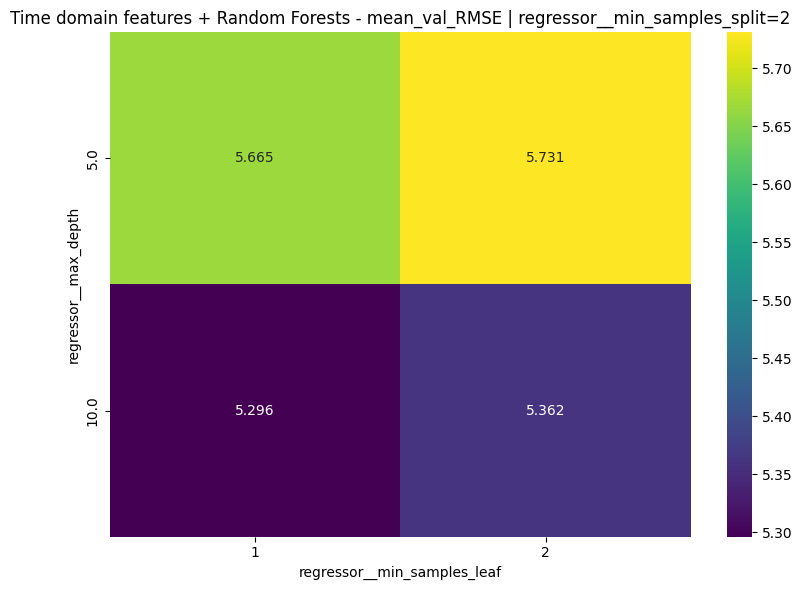

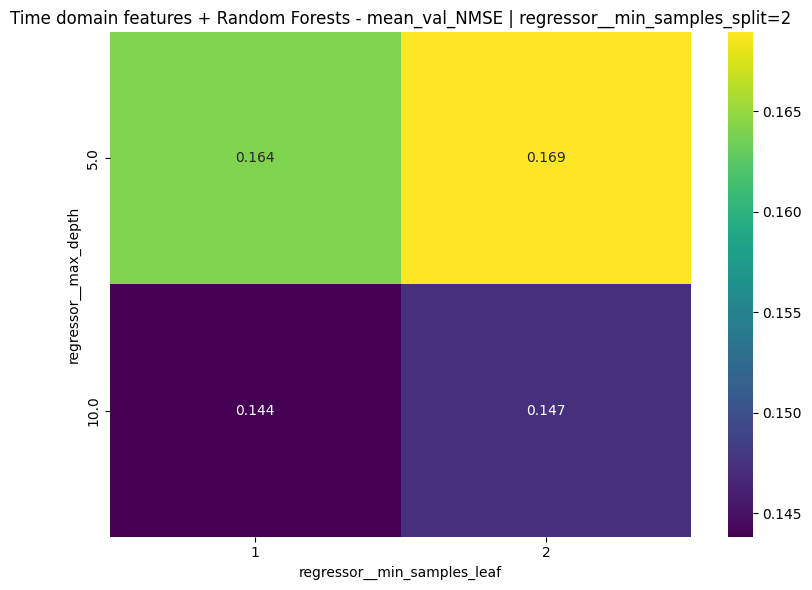

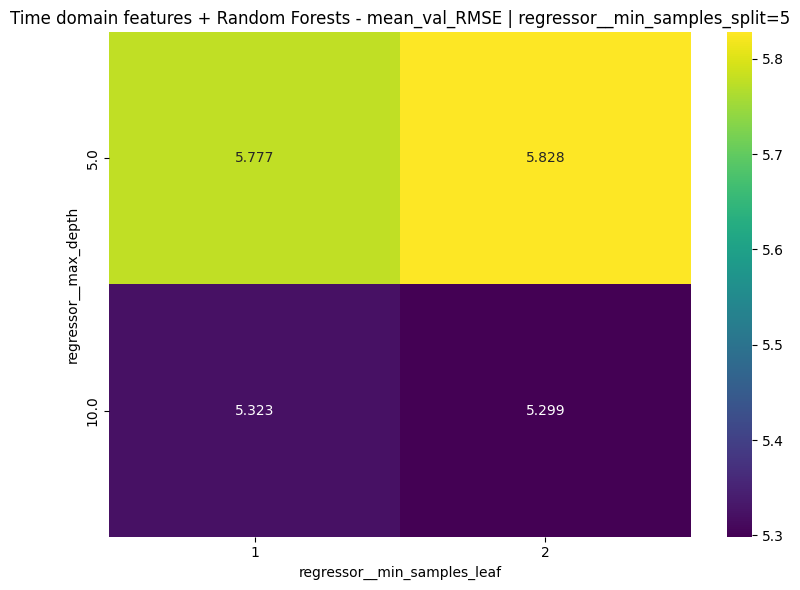

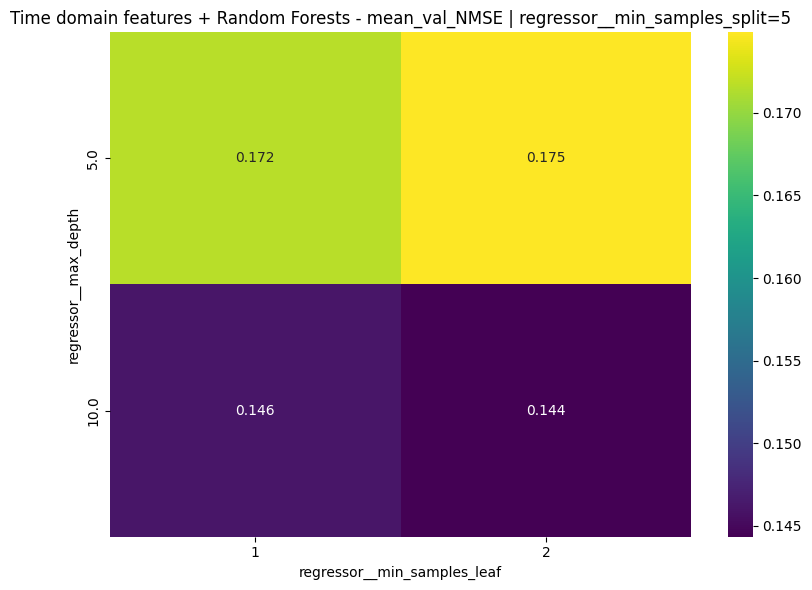

In [ ]:
def plot_grid_results(model_name, results):
    """
    Plots RMSE and NMSE heatmaps or line plots for a given model's grid search results.

    Args:
        model_name (str): name of the model
        results (list of dict): results from parameter tuning
    """
    df = pd.DataFrame(results)
    param_cols = [col for col in df['params'][0].keys()]
    for col in param_cols:
        df[f'param_{col}'] = df['params'].apply(lambda d: d[col])

    if len(param_cols) == 1:
        p = f'param_{param_cols[0]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            plt.figure(figsize=(8, 4))
            plt.plot(df[p], df[metric], marker='o')
            plt.xlabel(param_cols[0])
            plt.ylabel(metric)
            plt.title(f'{model_name} - {metric}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    elif len(param_cols) == 2:
        p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'
        for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
            pivot = df.pivot_table(index=p1, columns=p2, values=metric, aggfunc='mean')
            plt.figure(figsize=(8, 6))
            sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
            plt.title(f'{model_name} - {metric}')
            plt.xlabel(param_cols[1])
            plt.ylabel(param_cols[0])
            plt.tight_layout()
            plt.show()

    else:
        # For >2 hyperparameters, plot line plots for each value of the third+ param
        fixed_param = param_cols[2]
        values = df[f'param_{fixed_param}'].unique()
        for val in values:
            df_subset = df[df[f'param_{fixed_param}'] == val]
            p1, p2 = f'param_{param_cols[0]}', f'param_{param_cols[1]}'
            for metric in ['mean_val_RMSE', 'mean_val_NMSE']:
                pivot = df_subset.pivot_table(index=p1, columns=p2, values=metric, aggfunc='mean')
                plt.figure(figsize=(8, 6))
                sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
                plt.title(f'{model_name} - {metric} | {fixed_param}={val}')
                plt.xlabel(param_cols[1])
                plt.ylabel(param_cols[0])
                plt.tight_layout()
                plt.show()


for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

### Riemannian geometry pipelines

In [ ]:
import pyriemann

In [21]:
# Riemannian geometry of covariance matrices
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KernelRidge(
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', KNeighborsRegressor())
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('regressor', RandomForestRegressor())
    ]
)

In [24]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Riemann + Kernel Ridge': riem1,
    'Riemann + KNN': riem2,
    'Riemann + Random Forest': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Riemann + Kernel Ridge

Average Scores across folds:
RMSE: train=4.1274, val=5.6207
NMSE: train=0.0848, val=0.1591

Model: Riemann + KNN

Average Scores across folds:
RMSE: train=2.1140, val=5.1833
NMSE: train=0.0223, val=0.1358

Model: Riemann + Random Forest

Average Scores across folds:
RMSE: train=1.3251, val=4.9036
NMSE: train=0.0087, val=0.1230


In [25]:
param_grids = {
    'Riemann + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'regressor__gamma': [0.001, 0.01, 0.1],
        'regressor__kernel': ['laplacian', 'rbf', 'poly']
    },
    'Riemann + KNN': {
        'regressor__n_neighbors': [3, 5, 10, 20, 30],
        'regressor__weights': ['uniform', 'distance']
    },
    'Riemann + Random Forest': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}")
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Tuning Model: Riemann + Kernel Ridge

Tuning Model: Riemann + KNN

Tuning Model: Riemann + Random Forest


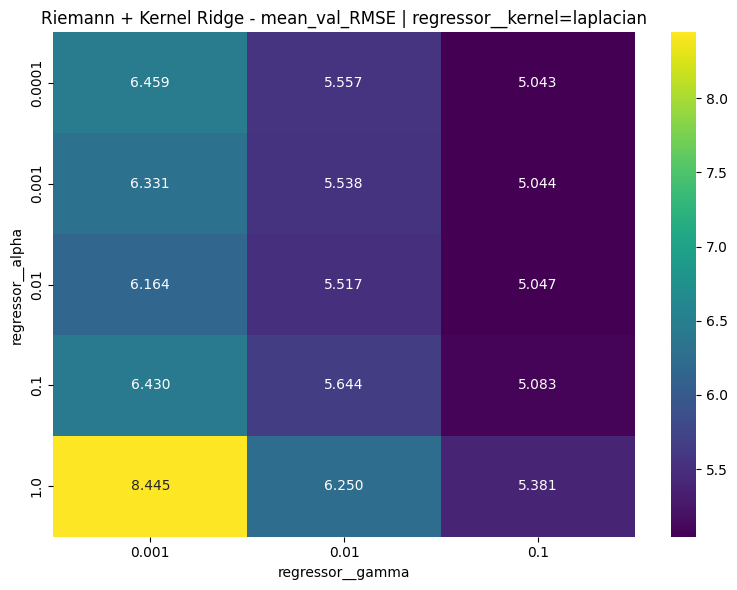

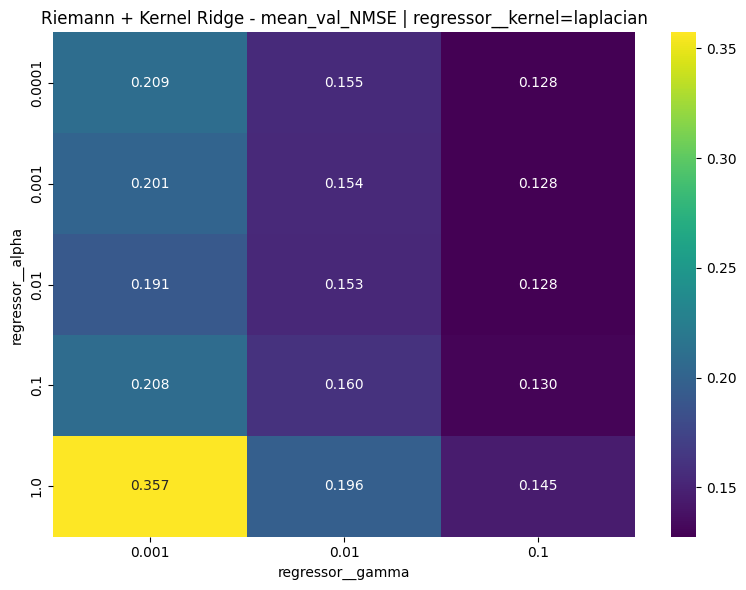

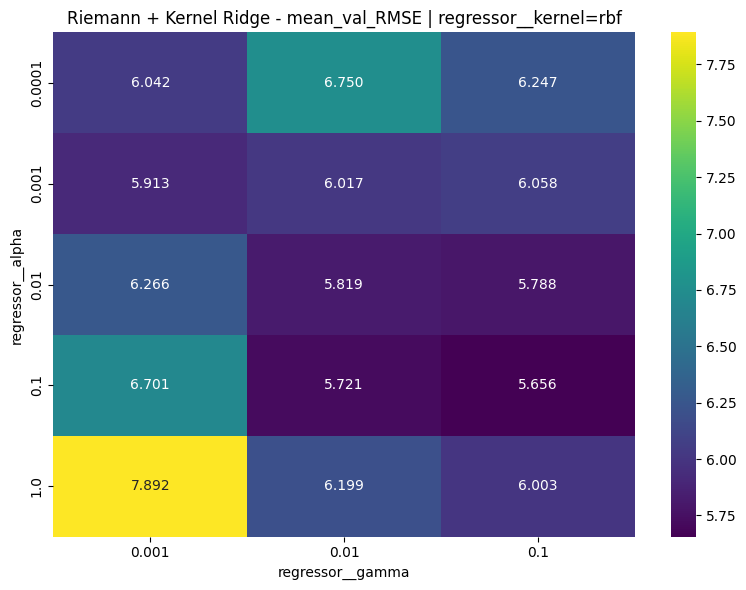

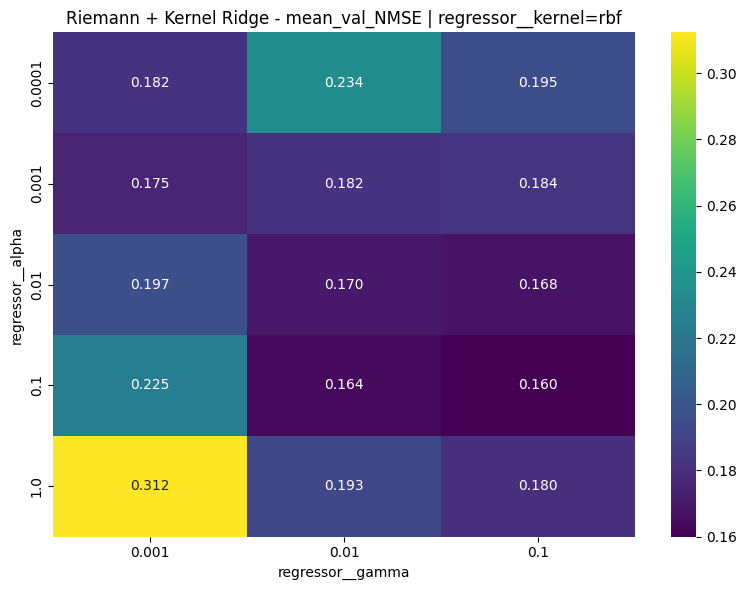

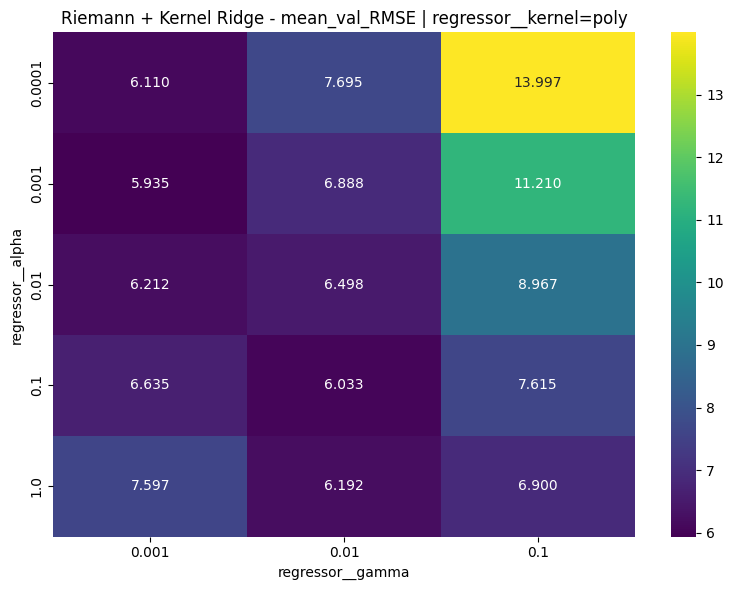

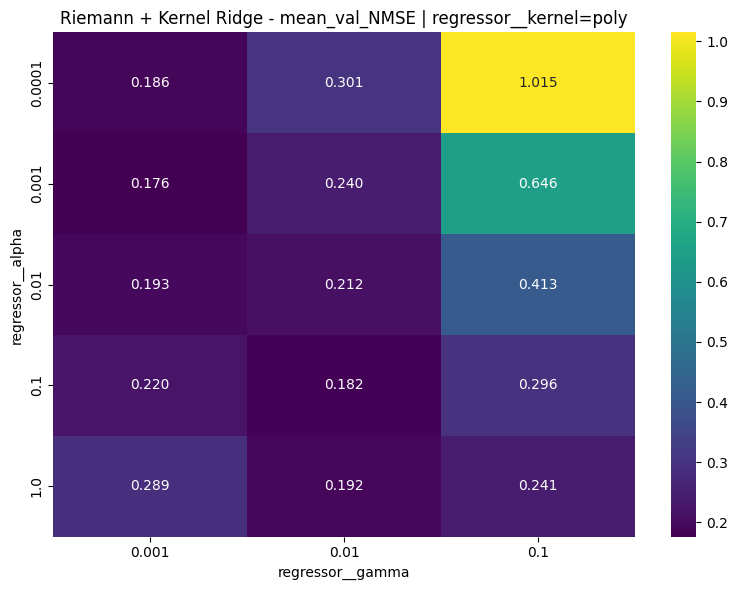

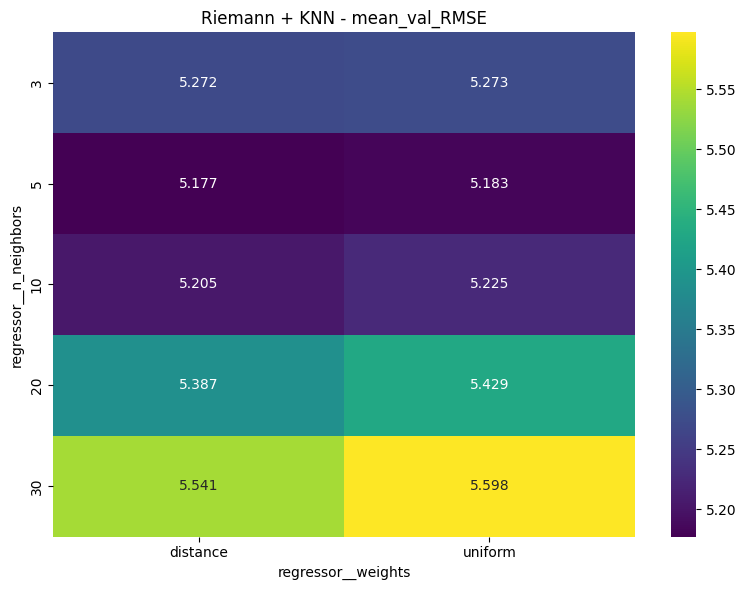

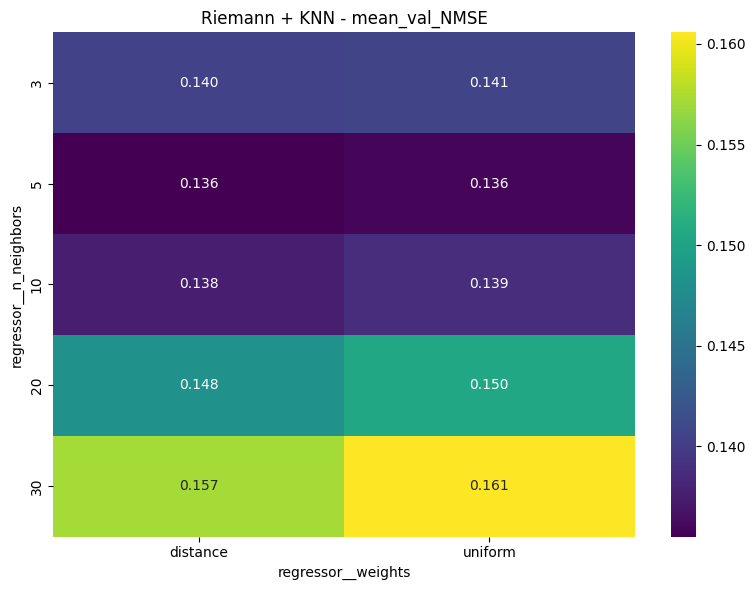

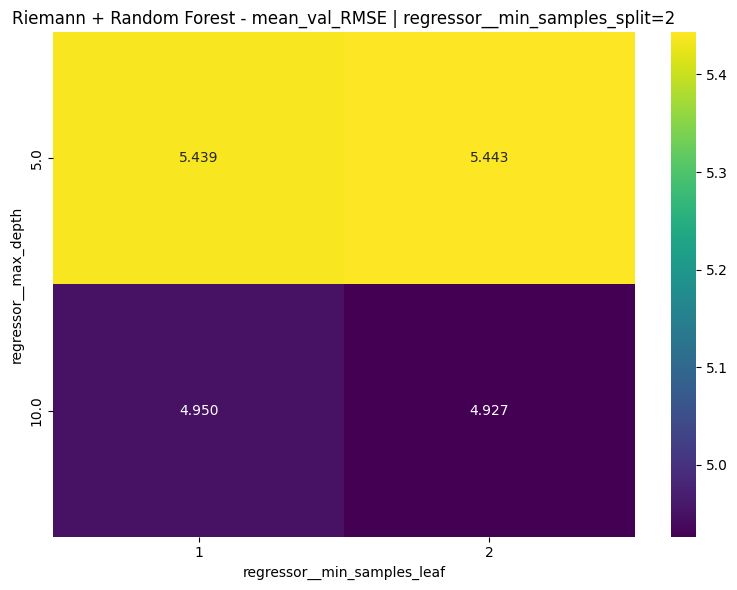

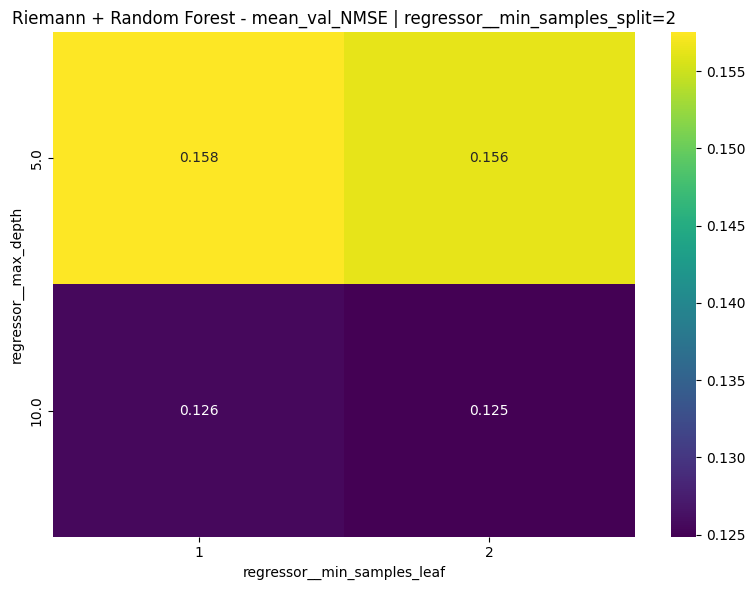

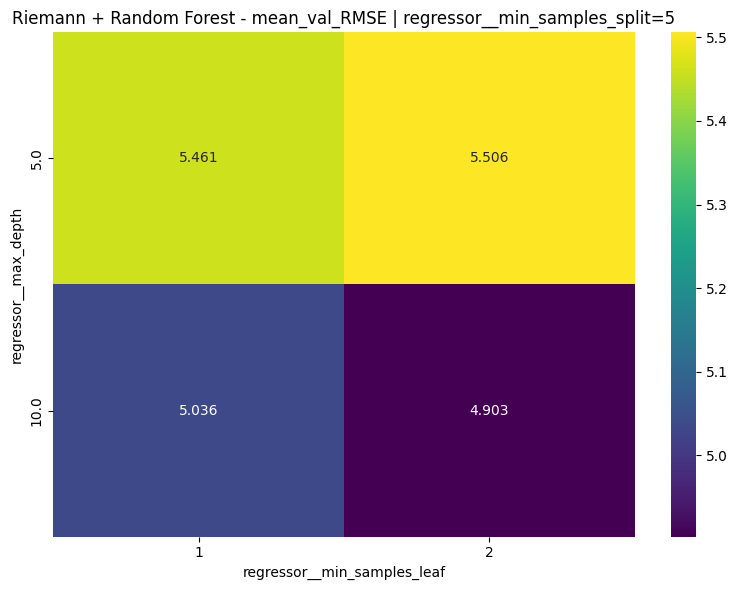

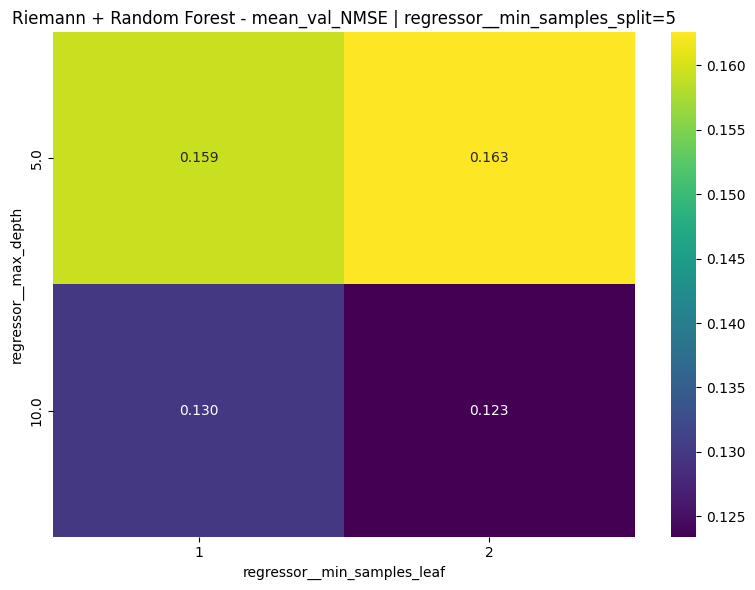

In [ ]:
for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

In [ ]:
import json

json_ready = {
    k: [{**d, 'params': {**d['params']}} for d in v]
    for k, v in all_results.items()
}

with open("logs/all_results_riemann.json", "w") as f:
    json.dump(json_ready, f, indent=2)

## Baseline models - freemoves

In [4]:
# loading raw data
# PATH = f'/Users/marco/PROJECTS/data/'
PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'freemoves' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

# Define parameters
size = 500
step = 250

# Initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# Apply transformations
X_windows = tw_transformer.transform(X)     # shape: (5, n_windows, 8, 500)
Y_labels = label_extractor.transform(Y)     # shape: (5, n_windows, 51)

# Inspect shapes
print("X_windows shape:", X_windows.shape)
print("Y_labels shape:", Y_labels.shape)

X_windows shape: (5, 1079, 8, 500)
Y_labels shape: (5, 1079, 51)


In [5]:
X_train_val_folds = X_windows[:4]
Y_train_val_folds = Y_labels[:4]
X_test = X_windows[4]
Y_test = Y_labels[4]

### Time features pipelines

In [8]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Time domain features + Kernel Ridge': baseline1,
    'Time domain features + KNN': baseline2,
    'Time domain features + Random Forests': baseline3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Time domain features + Kernel Ridge

Average Scores across folds:
RMSE: train=0.0583, val=11.1079
NMSE: train=0.0000, val=0.8280

Model: Time domain features + KNN

Average Scores across folds:
RMSE: train=6.5231, val=11.7761
NMSE: train=0.2589, val=0.9244

Model: Time domain features + Random Forests

Average Scores across folds:
RMSE: train=3.1093, val=10.8247
NMSE: train=0.0588, val=0.7819


In [11]:
param_grids = {
    'Time domain features + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        'regressor__gamma': [0.001, 0.01, 0.1],
        'regressor__kernel': ['rbf', 'laplacian', 'poly']
    },
    'Time domain features + KNN': {
        'regressor__n_neighbors': [3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50],
        'regressor__weights': ['uniform', 'distance']
    },
    'Time domain features + Random Forests': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10],
        # 'regressor__min_samples_split': [2, 5],
        # 'regressor__min_samples_leaf': [1, 2]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}") 
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Tuning Model: Time domain features + Kernel Ridge

Tuning Model: Time domain features + KNN

Tuning Model: Time domain features + Random Forests


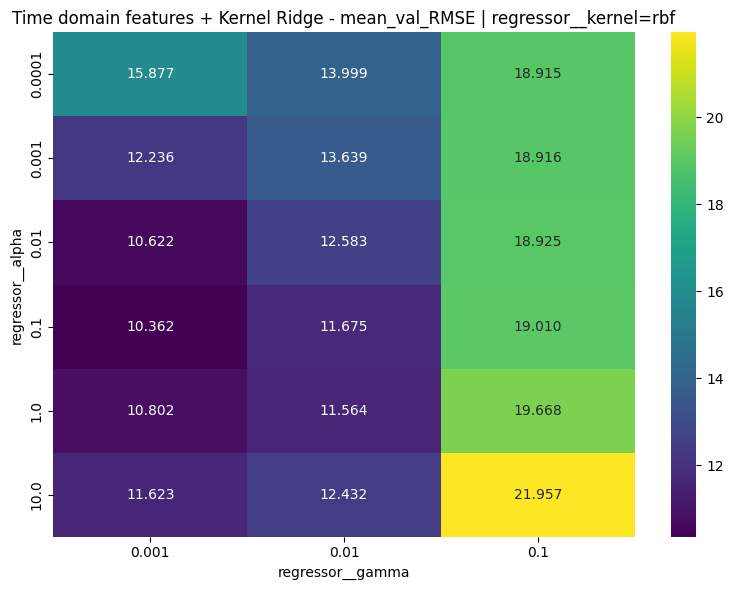

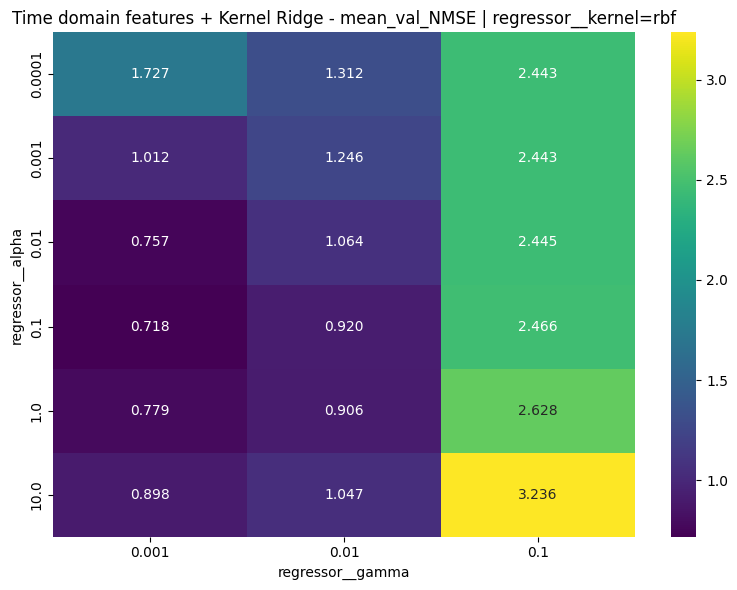

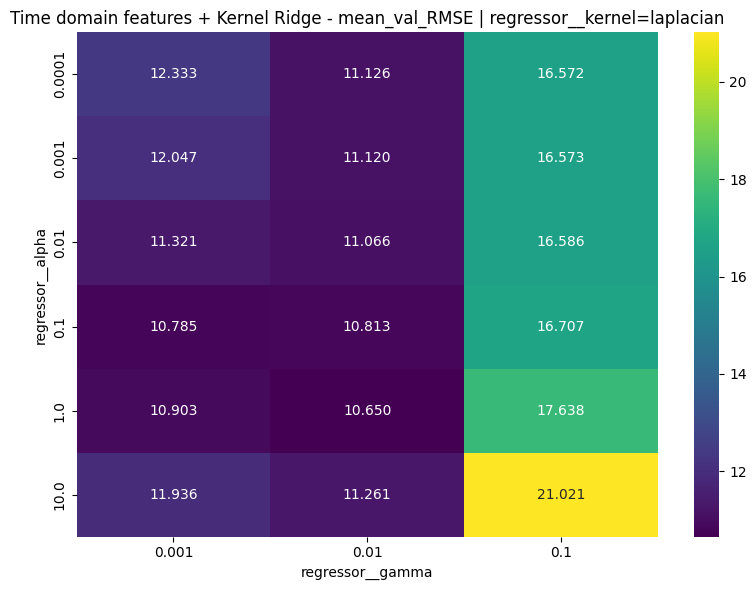

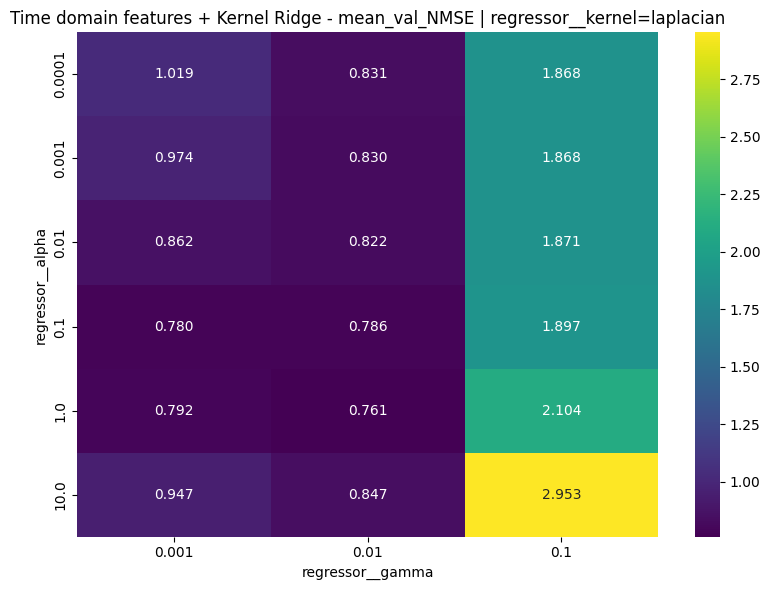

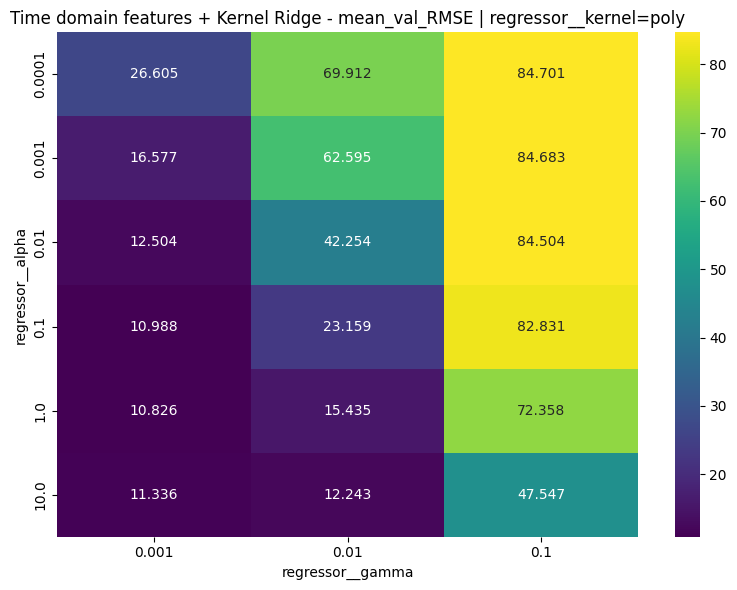

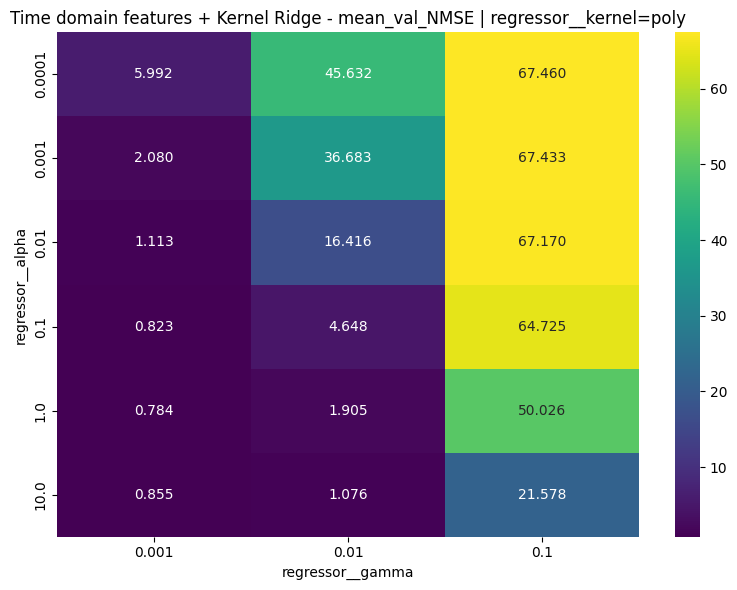

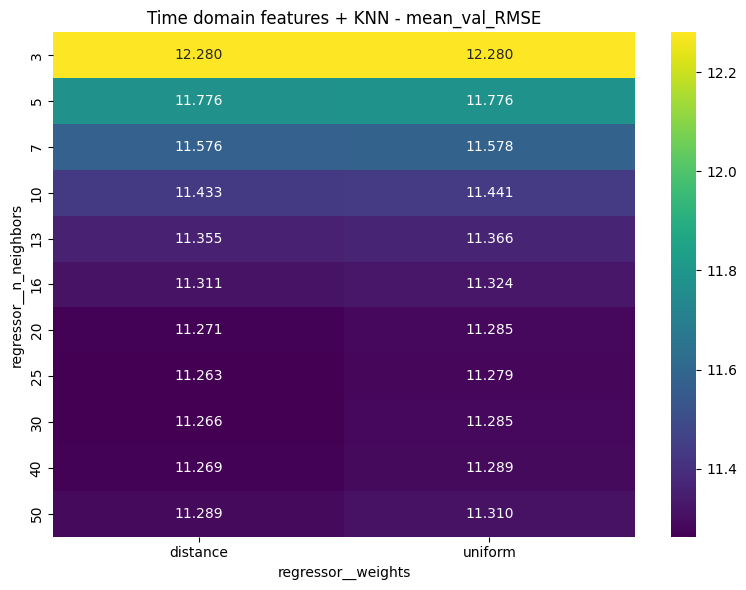

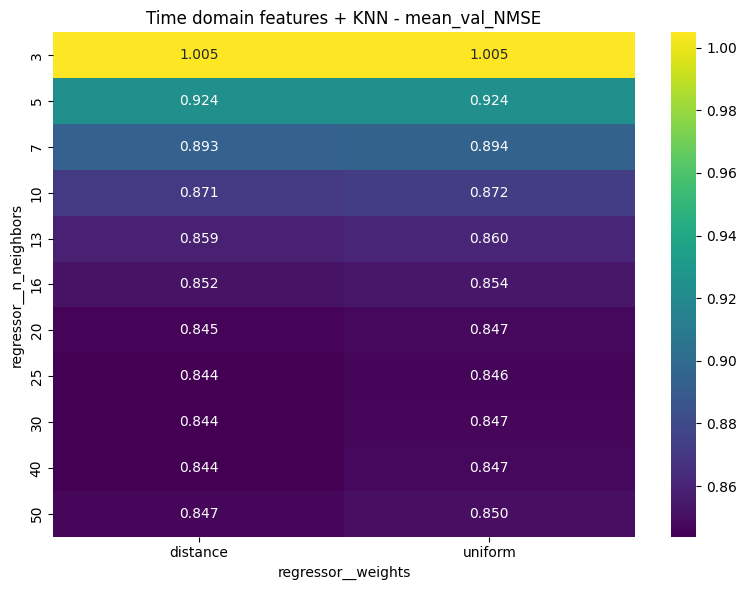

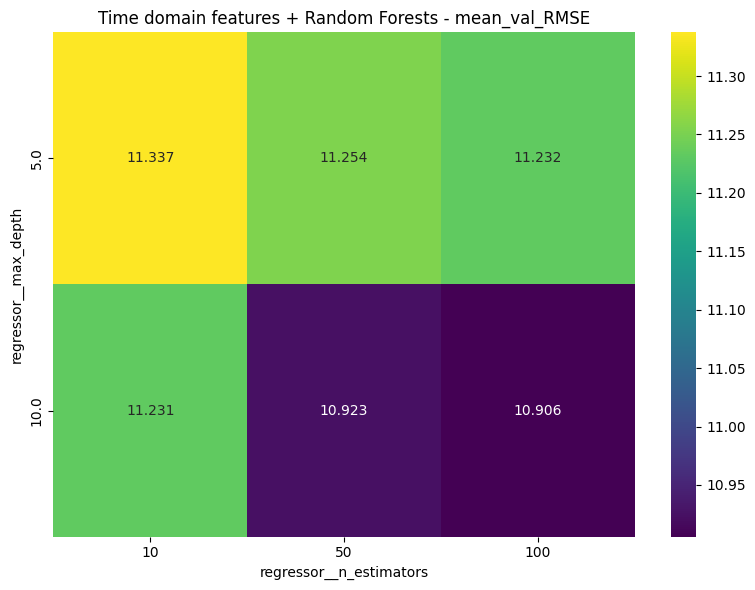

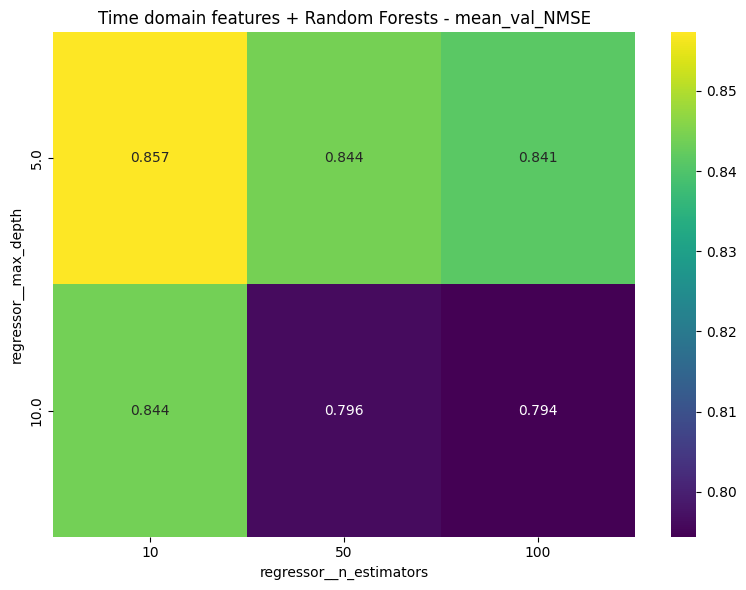

In [12]:
for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

In [13]:
import json

json_ready = {
    k: [{**d, 'params': {**d['params']}} for d in v]
    for k, v in all_results.items()
}

with open("logs/freemoves_results_regression.json", "w") as f:
    json.dump(json_ready, f, indent=2)

### Riemannian geometry pipelines

In [14]:
# Evaluation
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}
models = {
    'Riemann + Kernel Ridge': riem1,
    'Riemann + KNN': riem2,
    'Riemann + Random Forest': riem3
}

for model_name, model in models.items():
    print(f'\nModel: {model_name}')
    result = cross_validate_pipeline(model, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=1)


Model: Riemann + Kernel Ridge

Average Scores across folds:
RMSE: train=7.6979, val=11.0225
NMSE: train=0.3607, val=0.8136

Model: Riemann + KNN

Average Scores across folds:
RMSE: train=6.9531, val=12.0697
NMSE: train=0.2945, val=0.9754

Model: Riemann + Random Forest

Average Scores across folds:
RMSE: train=3.3011, val=11.2527
NMSE: train=0.0663, val=0.8472


In [15]:
param_grids = {
    'Riemann + Kernel Ridge': {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'regressor__gamma': [0.001, 0.01, 0.1],
        'regressor__kernel': ['laplacian', 'rbf', 'poly']
    },
    'Riemann + KNN': {
        'regressor__n_neighbors': [3, 5, 10, 20, 30],
        'regressor__weights': ['uniform', 'distance']
    },
    'Riemann + Random Forest': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 5, 10],
        # 'regressor__min_samples_split': [2, 5],
        # 'regressor__min_samples_leaf': [1, 2]
    }
}

all_results = {}

for model_name, pipeline in models.items():
    print(f"\nTuning Model: {model_name}")
    results = []

    for params in ParameterGrid(param_grids[model_name]):
        pipeline.set_params(**params)
        scores = cross_validate_pipeline(pipeline, X_train_val_folds, Y_train_val_folds, metric_fns)

        results.append({
            'params': params,
            'mean_train_RMSE': scores['avg_train_RMSE'],
            'mean_val_RMSE': scores['avg_val_RMSE'],
            'mean_train_NMSE': scores['avg_train_NMSE'],
            'mean_val_NMSE': scores['avg_val_NMSE']
        })

    all_results[model_name] = results


Tuning Model: Riemann + Kernel Ridge

Tuning Model: Riemann + KNN

Tuning Model: Riemann + Random Forest


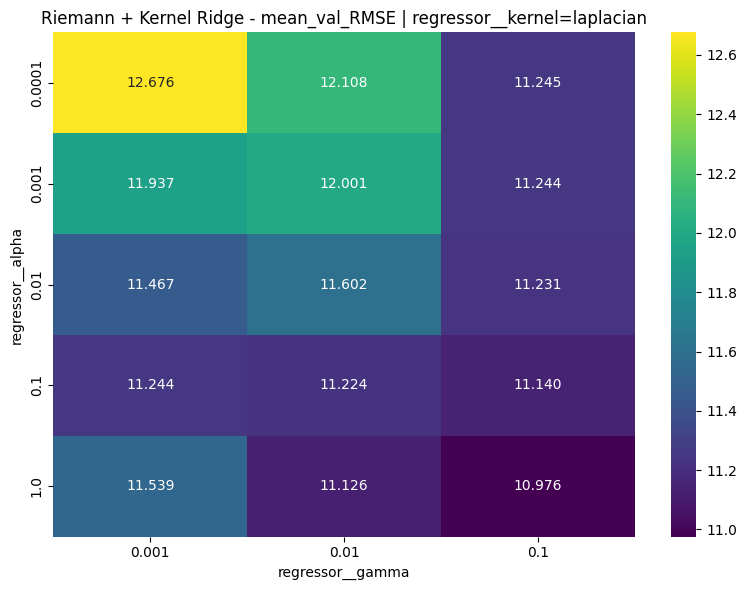

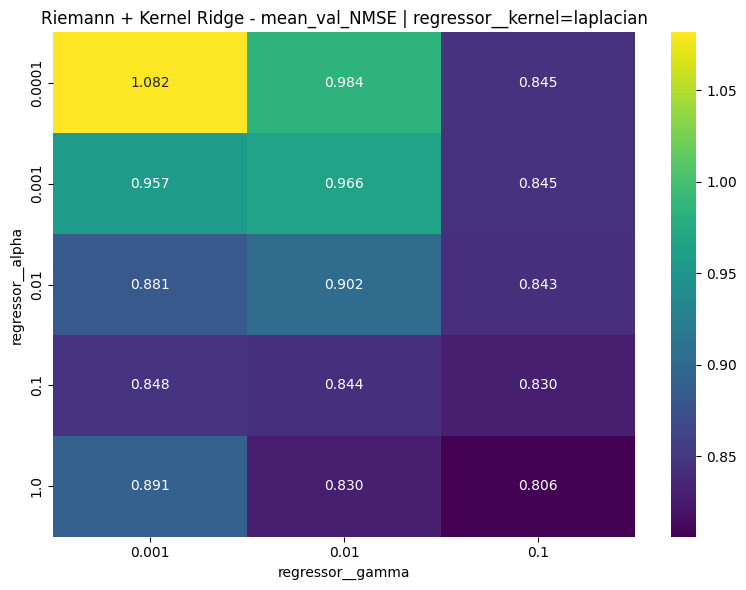

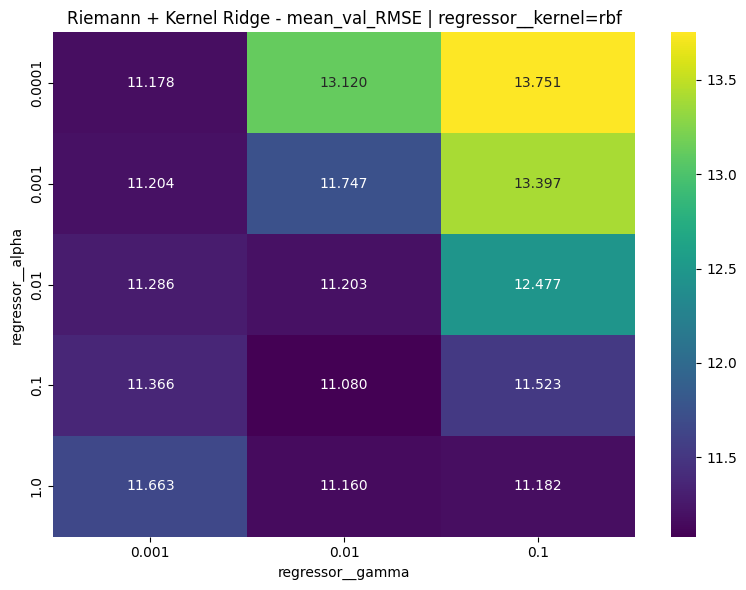

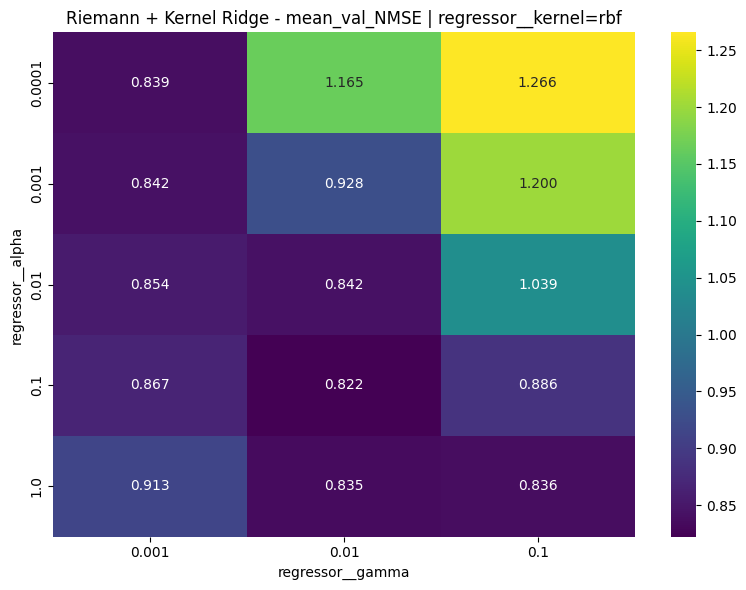

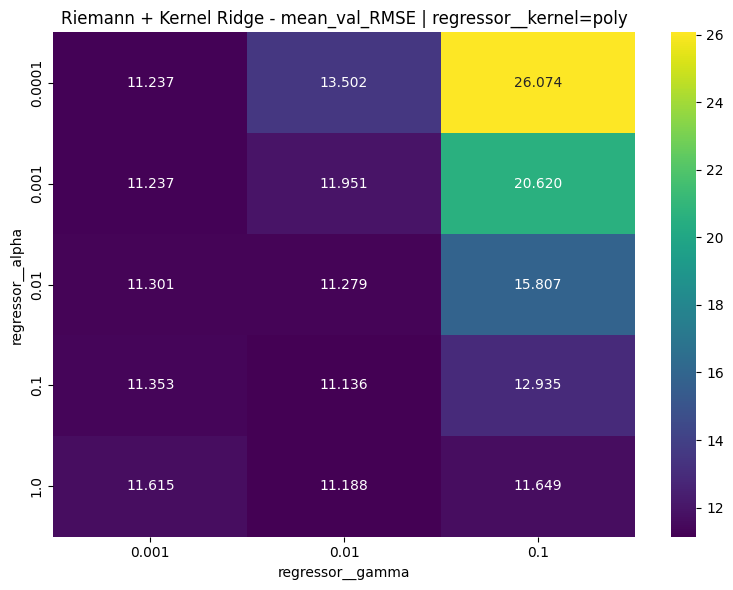

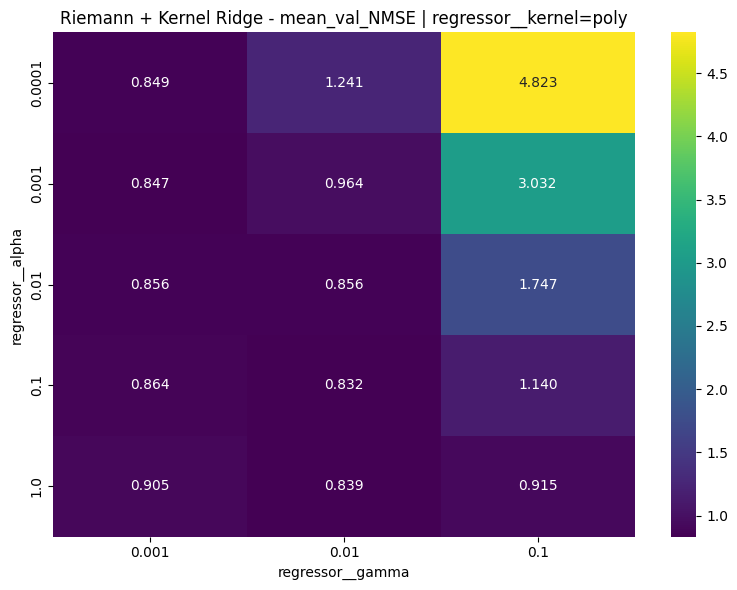

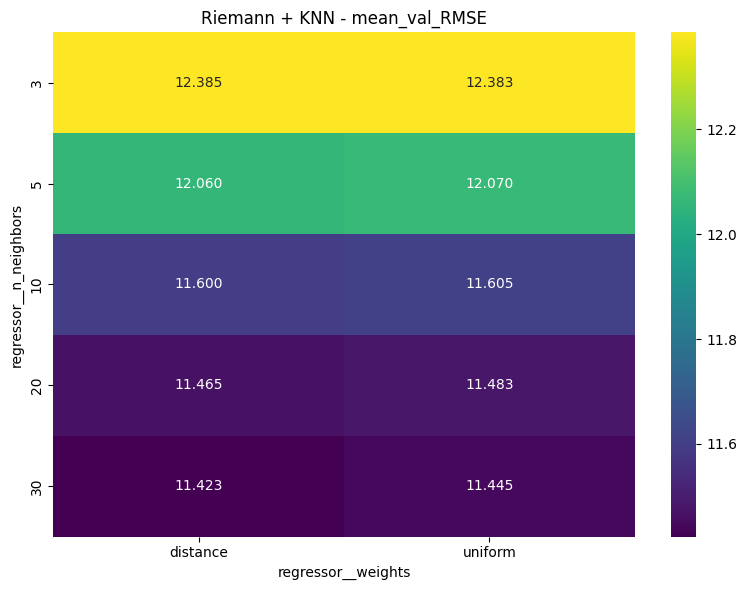

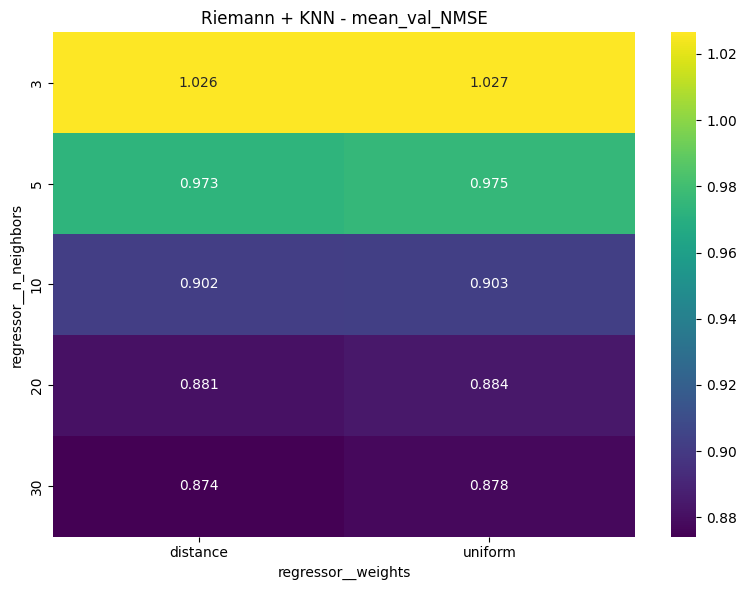

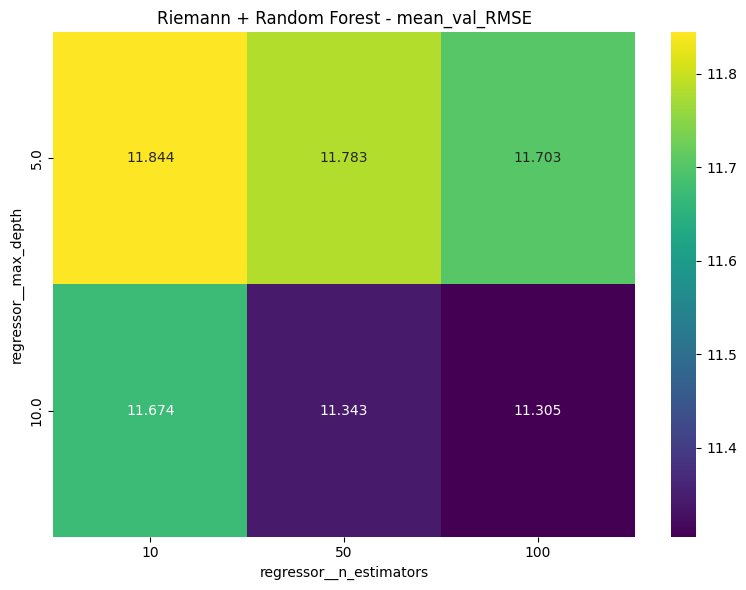

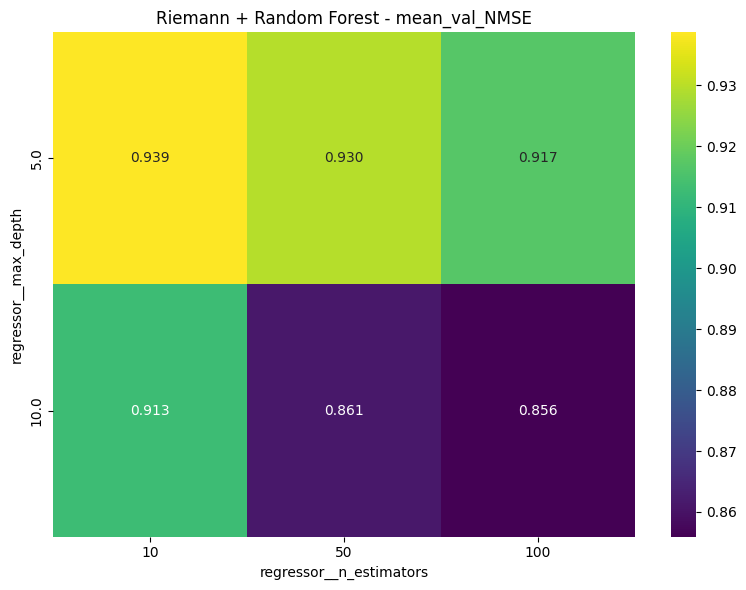

In [16]:
for model_name, results in all_results.items():
    plot_grid_results(model_name, results)

In [17]:
json_ready = {
    k: [{**d, 'params': {**d['params']}} for d in v]
    for k, v in all_results.items()
}

with open("logs/freemoves_results_riemann.json", "w") as f:
    json.dump(json_ready, f, indent=2)